# Part 1 - Model Training

This code looks at creating a linear regression model, looking at reproducing Moore's Law. 

In [1]:
# We first verify the correct version of TF installed
# !pip install -q tensorflow-gpu==2.1.0

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

2.8.0


In [2]:
# Obtaining the data - this is done using the wget method, to obtain the data from the instructor's github repo

!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv

# We then load the data, and split it into train data and labels, and reshape X to have it in the format accepted by Keras/Tensorflow
# We also check the shapes of X and y, to make sure they follow the required format

data = pd.read_csv('moore.csv', header=None).values
X = data[:,0]
print(X.shape)
X.reshape(-1,1)
print(X.shape)
y = data[:,1]
print(y.shape)

--2022-02-19 18:47:20--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2302 (2.2K) [text/plain]
Saving to: ‘moore.csv’

moore.csv           100%[===================>]   2.25K  --.-KB/s    in 0s      

2022-02-19 18:47:20 (35.4 MB/s) - ‘moore.csv’ saved [2302/2302]

(162,)
(162,)
(162,)


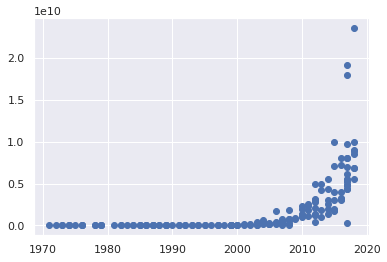

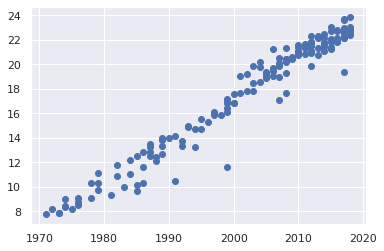

In [3]:
# To further check the data, we plot it
# In a scatter plot, it is exponential. If we take the log of y, the data follows a linear pattern.

plt.scatter(X,y)

plt.figure()
y_log = np.log(y)
plt.scatter(X,y_log)

In [4]:
# Currently, X is the year. For creating the model, we need to center X around 0
# This is done so that the values are not too large, as currently the values are large 
# This can either be done by scaling, but this means that latter the data would need to be reverse transformed.
# Scaling would also mean that a step increase in X would no longer be equivalent to a 1 year increase in real terms.

X = X - X.mean()

In [5]:
# Now, the Tensofrlow model is created. An input and dense layer are created.
# For linear regression, there is no activation function.
# Two models are created:
# - the first one uses the adam optimizer
# - the second one uses an optimizer object, with learning rate = 0.001, and momentum = 0.9 (this allows the user more control)
# The mean squared error (mse) is used as a loss function
# A learning rate scheduler is also created, to scale the learning rate based on the training epoch.

model_1 = tf.keras.models.Sequential(
    [
     tf.keras.layers.Input(shape=(1,)),
     tf.keras.layers.Dense(1)
    ]
)

model_1.compile(optimizer = 'adam', loss='mse')

model_2 = tf.keras.models.Sequential(
    [
     tf.keras.layers.Input(shape=(1,)),
     tf.keras.layers.Dense(1)
    ]
)

model_2.compile(optimizer = tf.keras.optimizers.SGD(0.001, 0.9), loss='mse')

def schedule(epoch, learning_rate):
  """This function schedules a variable learning rate based on the epoch number

  :param epoch: The current training epoch
  :type epoch: float
  :return: A value for the learning rate
  :rtype: float
  """
  if epoch >= 50:
    return 0.0001
  else:
    return 0.001

scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

r1 = model_1.fit(X, y_log, epochs = 200, callbacks=[scheduler])
r2 = model_2.fit(X, y_log, epochs = 200, callbacks=[scheduler])

Epoch 1/200
6/6 [==============================] - 3s 5ms/step - loss: 774.2862 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 4ms/step - loss: 770.8140 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 4ms/step - loss: 767.2462 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 4ms/step - loss: 763.6793 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 4ms/step - loss: 760.0212 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 0s 4ms/step - loss: 756.4388 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 752.9697 - lr: 0.0010
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 749.4721 - lr: 0.0010
Epoch 9/200
6/6 [==============================] - 0s 4ms/step - loss: 745.9452 - lr: 0.0010
Epoch 10/200
6/6 [==============================] - 0s 4ms/step - loss: 742.4930 - lr: 0.0010
Epoch 11/200
6/6 [==============================] - 0s 4ms/step - los

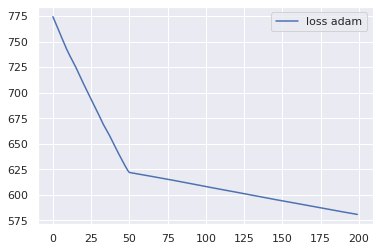

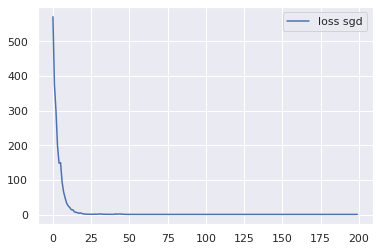

In [6]:
# To assess how the models perfored, we plot their loss per iteration.

plt.figure()
plt.plot(r1.history['loss'], label='loss adam')
plt.legend()

plt.figure()
plt.plot(r2.history['loss'], label='loss sgd')
plt.legend()

In [7]:
# To better understand the model, we would like to get the slope of the line, which is related to the doubling rate of the transistor count
# To get the trained weights of the model, we need to access the relevant layer.
# We can observe the input layer is a dummy-layer, keeping track of the input size.
# The '.get_weights' returns two arrays, representing W and b.

print(model_2.layers)
print(model_2.layers[0].get_weights())
print("The Slope:", model_2.layers[0].get_weights()[0][0,0])

[array([[0.34031764]], dtype=float32), array([17.77345], dtype=float32)]
The Slope: 0.34031764


In [8]:
print("Time to double:", np.log(2) / model_2.layers[0].get_weights()[0][0,0])

Time to double: 2.0367653796131684


In [9]:
# To verify the above calculation, the analytical solution of linear regression is also calculated.

X = np.array(X).flatten()
Y = np.array(y_log)
denominator = X.dot(X) - X.mean() * X.sum()
a = ( X.dot(Y) - Y.mean()*X.sum() ) / denominator
b = ( Y.mean() * X.dot(X) - X.mean() * X.dot(Y) ) / denominator
print(a, b)
print("Time to double:", np.log(2) / a)

0.341682487387313 17.764939393631764
Time to double: 2.0286295205239204


# Part 2 - Making Predictions

This code looks at how the previously trained models can be used in order to generate predictions

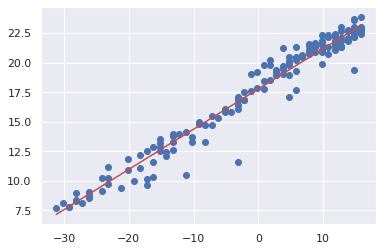

In [10]:
# We first check if the line obtained fits the data
Y_hat = model_2.predict(X).flatten()
plt.scatter(X,y_log)
plt.plot(X,Y_hat,'r')

In [11]:
# We can also perform a manual calculation

# Get the weights
w, b = model_2.layers[0].get_weights()

# Reshape X because we flattened it again earlier
X = X.reshape(-1, 1)

# (N x 1) x (1 x 1) + (1) --> (N x 1)
Y_hat2 = (X.dot(w) + b).flatten()

# Don't use == for floating points
np.allclose(Y_hat, Y_hat2)

True

# Part 3 - Making Predictions

This code looks at how the above model can be saved.

In [ ]:
model_2.save('linear_regression.h5')

In [ ]:
# Confirming file stored locally.
!ls -lh

total 40K
-rw-r--r-- 1 root root  18K Feb 10 18:26 linear_regression.h5
-rw-r--r-- 1 root root 2.3K Feb 10 17:16 moore.csv
-rw-r--r-- 1 root root 2.3K Feb 10 17:17 moore.csv.1
-rw-r--r-- 1 root root 2.3K Feb 10 17:17 moore.csv.2
-rw-r--r-- 1 root root 2.3K Feb 10 18:14 moore.csv.3
drwxr-xr-x 1 root root 4.0K Feb  5 18:37 sample_data


In [ ]:
# Let's load the model and confirm that it still works
# Note: there is a bug in Keras where load/save only works if you DON'T use the Input() layer explicitly
# So, make sure you define the model with ONLY Dense(1, input_shape=(D,))
# At least, until the bug is fixed
# https://github.com/keras-team/keras/issues/10417

model = tf.keras.models.load_model('linear_regression.h5')
print(model.layers)
model.evaluate(X, y_log)

162/162 [==============================] - 0s 263us/sample - loss: 0.9029


0.9029222660594516